Packages and Libraries:

In [9]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
annualization_factor=260
aspect_ratio=(12,8)

The read_price_data function loads a CSV file into a DataFrame, showing essential details like data structure, null values, and summary stats for a quick overview. It then returns the DataFrame for further analysis.

The function print_pct_data that “pretty-prints” a
table of percentage figures appropriately. This function takes in: (i) a required data_frame parameter, an optional string format specification an optional na_rep parameter (default: ‘NaN’- which is the string that gets printed for NaN values).

The function, calcPerformanceStatistics, takes a dataFrame of returns as input parameter (for simplicity, assume they are log returns and you can cumsum() them for cumulative returns) and three optional parameters: an annualization_factor (default: 260), a print_Screen flag
(default: True) and a percent_format_string string specification to print
percentage numbers (default: 2 decimal places). It then calculates the performance statistics of all the input return streams in the input dataFrame and, if printScreen is True, prints it out in the appropriate formats, using the pretty printing function print_pct_data.



In [10]:
# Invoking the read_price_data function used in HW1
def read_price_data(filename, index_col=0, parse_dates=True):

    # Read the CSV file into a DataFrame
    print("Reading the CSV file into a DataFrame...")
    df = pd.read_csv(filename, index_col=index_col, parse_dates=parse_dates)

    # Print the DataFrame's info
    print("\n1. DataFrame Information:")
    df.info()

    # Check for any null values in the DataFrame
    print("\n2. Checking for null values in the DataFrame:")
    print(df.isnull().sum())

    # Print summary statistics of the DataFrame
    print("\n3. Summary statistics of the DataFrame:")
    print(df.describe())

    # Display the first few rows of the DataFrame
    print("\n4. Displaying the first and last few rows of the DataFrame:")
    print(df)

    return df

In [11]:
def print_pct_data(data_frame, format_spec="{:.4%}", na_rep="NaN", index_slice=None):
    if index_slice is not None:
        # Apply formatting to the specified subset
        return data_frame.style.format(format_spec, na_rep=na_rep, subset=pd.IndexSlice[index_slice])
    else:
        # Apply formatting to the entire DataFrame
        return data_frame.style.format(format_spec, na_rep=na_rep)

In [12]:
def calcPerformanceStatistics(cum_log_returns_final, annualization_factor=260, print_screen=True, percent_format_string="{:.2%}"):

    if not cum_log_returns_final.iloc[0].isna().all():                 #first row null or not
        nan_row = pd.DataFrame([[np.nan] * len(cum_log_returns_final.columns)], columns=cum_log_returns_final.columns)
        cum_log_returns_final = pd.concat([nan_row, cum_log_returns_final]).reset_index(drop=True)

    # If there's a NaN row that isn't the first row or incomplete, raise an error
    if cum_log_returns_final.isna().sum(axis=1).max() > 0 and not cum_log_returns_final.iloc[0].isna().all():
        raise ValueError("First row must be entirely NaN and there should not be NaN values elsewhere in the data")

    # Drop the NaN row for further calculations
    cum_log_returns_final = cum_log_returns_final.dropna()

    # Cumulative return (assuming log returns, using .cumsum())
    cum_returns = cum_log_returns_final.cumsum()

    # Annualized Return: Mean of returns * annualization factor
    annualized_return = cum_log_returns_final.mean() * annualization_factor

    # Annualized Volatility (Standard Deviation of returns * sqrt of annualization factor)
    annualized_volatility = cum_log_returns_final.std() * np.sqrt(annualization_factor)

    # Sharpe Ratio: Annualized Return / Annualized Volatility
    sharpe_ratio = annualized_return / annualized_volatility

    # Maximum Drawdown: Max cumulative return - Min cumulative return
    drawdown = cum_returns.fillna(0).cumsum() - cum_returns.fillna(0).cumsum().cummax()
    max_drawdown = drawdown.min()

    # Create underwater curve
    underwater_curve = cum_returns.fillna(0) - np.maximum.accumulate(cum_returns.fillna(0))

    # Creating a DataFrame to hold the performance statistics
    performance_stats = pd.DataFrame({
        'Annualized Return': annualized_return,
        'Annualized Volatility': annualized_volatility,
        'Sharpe Ratio': sharpe_ratio,
        'Max Drawdown': max_drawdown
    })

    if print_screen:
        print("Performance Statistics:")
        display(print_pct_data(performance_stats, format_spec=percent_format_string))

    return performance_stats

##Question-1


The movingAverageCrossover function calculates fast and slow moving averages for an instrument, generates trading positions (Flat or Short) based on their crossover, and computes log returns adjusted by these positions. It returns the DataFrame with the added strategy data columns.

In [13]:
def movingAverageCrossover(df, fastWindow, slowWindow):
    instrument_name = df.columns[0]
    df=df[[instrument_name]]

    if df.shape[1] != 1:
        raise ValueError("Dataframe has >1 columns")

    instrument_name = df.columns[0]

    df['FastSMA'] = df[instrument_name].rolling(window=fastWindow).mean()
    df['SlowSMA'] = df[instrument_name].rolling(window=slowWindow).mean()

    df.dropna(inplace=True)

    df['Position-Flat'] = np.where(df['FastSMA'] > df['SlowSMA'], 1, 0)
    df['Position-Short'] = np.where(df['FastSMA'] > df['SlowSMA'], 1, -1)

    df[f'{instrument_name}-BMK-MA'] = np.log(df[instrument_name] / df[instrument_name].shift(1))


    df[f'{instrument_name}-MAFlat'] = df['Position-Flat'].shift(1) * df[f'{instrument_name}-BMK-MA']
    df[f'{instrument_name}-MAShort'] = df['Position-Short'].shift(1) * df[f'{instrument_name}-BMK-MA']

    return df

The bollingerBands function calculates Bollinger Bands (upper and lower) for an instrument using a specified lookback window and standard deviation multiplier. It then implements a trading strategy based on the instrument’s price relative to these bands, setting a position for each day (long, short, or flat) and calculating log returns adjusted by the position. The function returns the updated DataFrame with the Bollinger Bands and strategy columns.

In [14]:
def bollingerBands(df, lookbackWindow, stdevBand):
  instrument_name = df.columns[0]
  df=df[[instrument_name]]
  if df.shape[1] != 1:
        raise ValueError("Dataframe has >1 columns")

  instrument_name = df.columns[0]
  df.loc[:,'Mean'] = df[instrument_name].rolling(lookbackWindow).mean()
  df.loc[:,'Stdev'] = df[instrument_name].rolling(lookbackWindow).std()

  df.dropna(inplace=True)

  df.loc[:,'Upper'] = df['Mean'] + stdevBand * df['Stdev']
  df.loc[:,'Lower'] = df['Mean'] - stdevBand * df['Stdev']

  # now we implement the Bollinger band based strategy

# initialize the first row based on the close price vis-a-vis the bands
# here, we're also initializng a new column called 'Position'
# using .loc as before
  date0 = df.index[0]
  if df.loc[date0,instrument_name] >= df.loc[date0, 'Upper']:
      df.loc[date0, 'Position-BB'] = -1
  elif df.loc[date0,instrument_name] <= df.loc[date0,'Lower']:
      df.loc[date0, 'Position-BB'] = 1
  else:
      df.loc[date0, 'Position-BB'] = 0

  # then loop over the entire data set
  for i in range(1, df.shape[0]):
      today=df.index[i]
      yesterday=df.index[i-1]
      if df.loc[today,instrument_name] >= df.loc[today,'Upper']: # if close is above upper
          df.loc[today,'Position-BB'] = -1 # then go short
      elif df.loc[today,instrument_name] <= df.loc[today,'Lower']: # if close is below lower
          df.loc[today,'Position-BB'] = 1 # then go long
      elif df.loc[yesterday,'Position-BB'] == -1 and df.loc[today,instrument_name] <= df.loc[today,'Mean']: # if prev day is short and we're now below the mean
          df.loc[today,'Position-BB']=0 # then flatten
      elif df.loc[yesterday,'Position-BB'] == 1 and df.loc[today, instrument_name] >= df.loc[today, 'Mean']: # conversely...
          df.loc[today,'Position-BB']=0 # then also flatten
      else: # otherwise just hold yesterday's position
          df.loc[today,'Position-BB']=df.loc[yesterday,'Position-BB']

  df[f'{instrument_name}--BMK--BB'] = np.log(df[instrument_name] / df[instrument_name].shift(1))
  df[f'{instrument_name}--BB'] = df['Position-BB'].shift(1) * df[f'{instrument_name}--BMK--BB']

  return df

The runMovingAverageAndBB function applies both the moving average crossover and Bollinger Bands strategies to a DataFrame. It merges the results from each strategy into a final DataFrame, df_final, which includes data columns from both strategies, and returns it for further analysis.

In [15]:
def runMovingAverageAndBB(dataFrame, fastWindow, slowWindow, bbWindow, stdevBand):
    ma_result = movingAverageCrossover(dataFrame, fastWindow, slowWindow)

    bb_result = bollingerBands(dataFrame, bbWindow, stdevBand)

    df_final = ma_result.merge(bb_result, how='inner',left_index=True, right_index=True)

    return df_final

##Question-2

In [16]:
import pandas as pd

# Load the data from the CSV file
allprices_df = pd.read_csv('PricesProjectA.csv', index_col=0, parse_dates=True)

# Display the first few rows of the DataFrame to understand its structure
print(allprices_df.head())
print(allprices_df.tail())

                AAPL      AMZN        ATT     AUD     EUR  FBNDX          GE  \
Date                                                                           
1999-12-31  0.917969  3.806250  36.820244  0.6567  1.0062   6.89  396.794861   
2000-01-03  0.999442  4.468750  35.498489  0.6585  1.0243   6.85  384.615387   
2000-01-04  0.915179  4.096875  33.421452  0.6550  1.0296   6.87  369.230774   
2000-01-05  0.928571  3.487500  33.940708  0.6579  1.0321   6.84  368.589752   
2000-01-06  0.848214  3.278125  33.043808  0.6533  1.0328   6.86  373.517639   

              GOLD      INTC        LEHM  SILVER       SPY  
Date                                                        
1999-12-31  288.00  41.15625  798.154631   5.380  146.8750  
2000-01-03  289.00  43.50000  793.868670   5.405  145.4375  
2000-01-04  282.25  41.46875  796.761677   5.325  139.7500  
2000-01-05  280.00  41.81250  793.118215   5.145  140.0000  
2000-01-06  281.10  39.37500  795.091984   5.120  137.7500  
            

This code extracts individual columns from allprices_df for specific assets (like AAPL, AMZN, etc.), creating separate DataFrames for each. Each asset’s data is stored in its respective DataFrame (e.g., aapl for Apple, amzn for Amazon), allowing for easy access and analysis of each asset individually.

In [17]:
# Data preparation of each security

aapl = allprices_df[['AAPL']]
amzn = allprices_df[['AMZN']]
intc = allprices_df[['INTC']]
att = allprices_df[['ATT']]
ge = allprices_df[['GE']]
spy = allprices_df[['SPY']]
gold = allprices_df[['GOLD']]
silver = allprices_df[['SILVER']]
fbndx = allprices_df[['FBNDX']]
lehm = allprices_df[['LEHM']]
aud = allprices_df[['AUD']]
eur = allprices_df[['EUR']]


##Question- 3, 4 and 5, 6

Selecting 5 Equity Instruments out of 6, 1 fixed income instrument, 1 commodity instrument, 1 currency.

Equity Instruments:


*   AAPL
*   AMZN
*   GE
*   INTC
*   SPY

Commodity Instrument
*   LEHM

Commodity Instrument
*   GOLD

Currency
*   EUR

In [18]:
maFast = 46
maSlow = 260
bbWindow = 20
bbStdevBand = 2

Note: We have created a scatter plot fo obtaining maFast and maSlow, which would be the same for all our 12 securitie in the dataframe. The code for the same exists, but we have not mentioned the same in this noteook, to maintain brevity of the notebook.

We will run both the moving average and Bollinger Band strategies on the securities, then select key strategy columns for analysis.

The columns used below represent different strategy-based returns for all the securities. Here’s a breakdown:

- AAPL-BMK-MA: The benchmark (BMK) returns without applying any strategy.
- AAPL-MAFlat: Returns based on the moving average (MA) crossover strategy in a “flat” position.
- AAPL-MAShort: Returns from the moving average crossover strategy when taking short positions.
- AAPL--BB: The Bollinger Band (BB) strategy returns, which adjusts positions based on the price relative to the upper and lower bands.
- AAPL--BMK--BB: Benchmark returns related to the Bollinger Band setup without strategy adjustments.

APPLE-

we start by applying both the moving average and Bollinger Band strategies to the AAPL data, bringing in the key signals and returns for each strategy. Then, we dive into the performance stats, using these selected columns to calculate metrics like the Sharpe Ratio, all neatly stored in stats_aapl for review.

In [19]:
df_aapl = runMovingAverageAndBB(aapl, maFast, maSlow, bbWindow, bbStdevBand)

df_aapl_selected = df_aapl[['AAPL-BMK-MA', 'AAPL-MAFlat', 'AAPL-MAShort', 'AAPL--BB', 'AAPL--BMK--BB']]
stats_aapl=calcPerformanceStatistics(df_aapl_selected, annualization_factor=260, print_screen=False, percent_format_string="{:.2%}")


stats_aapl

,Annualized Return,Annualized Volatility,Sharpe Ratio,Max Drawdown
AAPL-BMK-MA,0.278819,0.370138,0.753284,-40.819702
AAPL-MAFlat,0.230018,0.284368,0.808874,-60.716179
AAPL-MAShort,0.181217,0.370371,0.489284,-147.789965
AAPL--BB,-0.115236,0.275271,-0.418627,-3644.560178
AAPL--BMK--BB,0.278819,0.370138,0.753284,-40.819702


AMAZON

Here, we’re putting Amazon (AMZN) through the same strategic setup, running both the moving average and Bollinger Band strategies with our defined parameters. Once we gather the key columns for each strategy, we calculate performance stats like the Sharpe Ratio and save them in stats_amzn for further analysis.

In [20]:
df_amzn = runMovingAverageAndBB(amzn, maFast, maSlow, bbWindow, bbStdevBand)
df_amzn_selected = df_amzn[['AMZN-BMK-MA', 'AMZN-MAFlat', 'AMZN-MAShort', 'AMZN--BB', 'AMZN--BMK--BB']]
stats_amzn = calcPerformanceStatistics(df_amzn_selected, annualization_factor=260, print_screen=False, percent_format_string="{:.2%}")
stats_amzn

,Annualized Return,Annualized Volatility,Sharpe Ratio,Max Drawdown
AMZN-BMK-MA,0.259787,0.489128,0.531122,-115.915456
AMZN-MAFlat,0.213081,0.333188,0.639521,-0.046958
AMZN-MAShort,0.166375,0.489285,0.340037,-1.423759
AMZN--BB,0.059043,0.352080,0.167699,-0.827282
AMZN--BMK--BB,0.259787,0.489128,0.531122,-115.915456


INTEL

we apply the moving average (MA) and Bollinger Band (BB) strategies with defined maFast, maSlow, bbWindow, and stdevBand parameters, extract columns for BMK-MA, MAFlat, MAShort, and BB returns, then calculate performance metrics, including the Sharpe Ratio, for direct comparison across instruments.

In [21]:
# INTC
df_intc = runMovingAverageAndBB(intc, maFast, maSlow, bbWindow, bbStdevBand)
df_intc_selected = df_intc[['INTC-BMK-MA', 'INTC-MAFlat', 'INTC-MAShort', 'INTC--BB', 'INTC--BMK--BB']]
stats_intc = calcPerformanceStatistics(df_intc_selected, annualization_factor=260, print_screen=False, percent_format_string="{:.2%}")
stats_intc


,Annualized Return,Annualized Volatility,Sharpe Ratio,Max Drawdown
INTC-BMK-MA,0.019759,0.352048,0.056127,-1331.948092
INTC-MAFlat,-0.007890,0.207550,-0.038013,-662.825597
INTC-MAShort,-0.035539,0.352043,-0.100950,-802.041431
INTC--BB,0.082284,0.249602,0.329661,-0.370087
INTC--BMK--BB,0.019759,0.352048,0.056127,-1331.948092


AT&T

we apply the moving average (MA) and Bollinger Band (BB) strategies with defined maFast, maSlow, bbWindow, and stdevBand parameters, extract columns for BMK-MA, MAFlat, MAShort, and BB returns, then calculate performance metrics, including the Sharpe Ratio, for direct comparison across instruments.

In [22]:
# ATT
df_att = runMovingAverageAndBB(att, maFast, maSlow, bbWindow, bbStdevBand)
df_att_selected = df_att[['ATT-BMK-MA', 'ATT-MAFlat', 'ATT-MAShort', 'ATT--BB', 'ATT--BMK--BB']]
stats_att = calcPerformanceStatistics(df_att_selected, annualization_factor=260, print_screen=False, percent_format_string="{:.2%}")
stats_att


,Annualized Return,Annualized Volatility,Sharpe Ratio,Max Drawdown
ATT-BMK-MA,-0.035196,0.251193,-0.140113,-2275.650547
ATT-MAFlat,-0.010759,0.128637,-0.083636,-830.541923
ATT-MAShort,0.013678,0.251201,0.054451,-107.824769
ATT--BB,0.047643,0.188058,0.253340,-1.643945
ATT--BMK--BB,-0.035196,0.251193,-0.140113,-2275.650547


GENERAL ELECTRIC

we apply the moving average (MA) and Bollinger Band (BB) strategies with defined maFast, maSlow, bbWindow, and stdevBand parameters, extract columns for BMK-MA, MAFlat, MAShort, and BB returns, then calculate performance metrics, including the Sharpe Ratio, for direct comparison across instruments.

In [23]:
# GE
df_ge = runMovingAverageAndBB(ge, maFast, maSlow, bbWindow, bbStdevBand)
df_ge_selected = df_ge[['GE-BMK-MA', 'GE-MAFlat', 'GE-MAShort', 'GE--BB', 'GE--BMK--BB']]
stats_ge = calcPerformanceStatistics(df_ge_selected, annualization_factor=260, print_screen=False, percent_format_string="{:.2%}")
stats_ge


,Annualized Return,Annualized Volatility,Sharpe Ratio,Max Drawdown
GE-BMK-MA,-0.105310,0.308586,-0.341267,-2724.640651
GE-MAFlat,-0.006335,0.141307,-0.044832,-129.341745
GE-MAShort,0.092640,0.308602,0.300193,-3.330338
GE--BB,-0.083003,0.245163,-0.338563,-2975.234869
GE--BMK--BB,-0.105310,0.308586,-0.341267,-2724.640651


S&P 500 ETF

we apply the moving average (MA) and Bollinger Band (BB) strategies with defined maFast, maSlow, bbWindow, and stdevBand parameters, extract columns for BMK-MA, MAFlat, MAShort, and BB returns, then calculate performance metrics, including the Sharpe Ratio, for direct comparison across instruments.

In [24]:
# SPY
df_spy = runMovingAverageAndBB(spy, maFast, maSlow, bbWindow, bbStdevBand)
df_spy_selected = df_spy[['SPY-BMK-MA', 'SPY-MAFlat', 'SPY-MAShort', 'SPY--BB', 'SPY--BMK--BB']]
stats_spy = calcPerformanceStatistics(df_spy_selected, annualization_factor=260, print_screen=False, percent_format_string="{:.2%}")
stats_spy


,Annualized Return,Annualized Volatility,Sharpe Ratio,Max Drawdown
SPY-BMK-MA,0.036895,0.192759,0.191407,-367.408651
SPY-MAFlat,0.059983,0.115322,0.520131,0.000000
SPY-MAShort,0.083070,0.192704,0.431075,-0.436120
SPY--BB,0.034541,0.142713,0.242030,-176.489690
SPY--BMK--BB,0.036895,0.192759,0.191407,-367.408651


GOLD

we apply the moving average (MA) and Bollinger Band (BB) strategies with defined maFast, maSlow, bbWindow, and stdevBand parameters, extract columns for BMK-MA, MAFlat, MAShort, and BB returns, then calculate performance metrics, including the Sharpe Ratio, for direct comparison across instruments.

In [25]:
# GOLD
df_gold = runMovingAverageAndBB(gold, maFast, maSlow, bbWindow, bbStdevBand)
df_gold_selected = df_gold[['GOLD-BMK-MA', 'GOLD-MAFlat', 'GOLD-MAShort', 'GOLD--BB', 'GOLD--BMK--BB']]
stats_gold = calcPerformanceStatistics(df_gold_selected, annualization_factor=260, print_screen=False, percent_format_string="{:.2%}")
stats_gold


,Annualized Return,Annualized Volatility,Sharpe Ratio,Max Drawdown
GOLD-BMK-MA,0.091575,0.179729,0.509515,-0.509129
GOLD-MAFlat,0.071948,0.145320,0.495098,-1.031152
GOLD-MAShort,0.052321,0.179790,0.291013,-7.073452
GOLD--BB,0.002387,0.134860,0.017699,-16.254827
GOLD--BMK--BB,0.091575,0.179729,0.509515,-0.509129


SILVER

we apply the moving average (MA) and Bollinger Band (BB) strategies with defined maFast, maSlow, bbWindow, and stdevBand parameters, extract columns for BMK-MA, MAFlat, MAShort, and BB returns, then calculate performance metrics, including the Sharpe Ratio, for direct comparison across instruments.

In [26]:
# SILVER
df_silver = runMovingAverageAndBB(silver, maFast, maSlow, bbWindow, bbStdevBand)
df_silver_selected = df_silver[['SILVER-BMK-MA', 'SILVER-MAFlat', 'SILVER-MAShort', 'SILVER--BB', 'SILVER--BMK--BB']]
stats_silver = calcPerformanceStatistics(df_silver_selected, annualization_factor=260, print_screen=False, percent_format_string="{:.2%}")
stats_silver


,Annualized Return,Annualized Volatility,Sharpe Ratio,Max Drawdown
SILVER-BMK-MA,0.070783,0.311694,0.227091,-12.236311
SILVER-MAFlat,0.072658,0.241599,0.300739,-3.710673
SILVER-MAShort,0.074534,0.311690,0.239127,-7.977381
SILVER--BB,-0.039337,0.230709,-0.170505,-1832.947993
SILVER--BMK--BB,0.070783,0.311694,0.227091,-12.236311


Fidelity Investment Grade Bond Index

we apply the moving average (MA) and Bollinger Band (BB) strategies with defined maFast, maSlow, bbWindow, and stdevBand parameters, extract columns for BMK-MA, MAFlat, MAShort, and BB returns, then calculate performance metrics, including the Sharpe Ratio, for direct comparison across instruments.

In [27]:
# FBNDX
df_fbndx = runMovingAverageAndBB(fbndx, maFast, maSlow, bbWindow, bbStdevBand)
df_fbndx_selected = df_fbndx[['FBNDX-BMK-MA', 'FBNDX-MAFlat', 'FBNDX-MAShort', 'FBNDX--BB', 'FBNDX--BMK--BB']]
stats_fbndx = calcPerformanceStatistics(df_fbndx_selected, annualization_factor=260, print_screen=False, percent_format_string="{:.2%}")
stats_fbndx


,Annualized Return,Annualized Volatility,Sharpe Ratio,Max Drawdown
FBNDX-BMK-MA,0.003746,0.038144,0.098217,-31.080773
FBNDX-MAFlat,0.003786,0.026678,0.141906,-75.538823
FBNDX-MAShort,0.003825,0.038144,0.100282,-147.337176
FBNDX--BB,-0.003604,0.027979,-0.128799,-144.691707
FBNDX--BMK--BB,0.003746,0.038144,0.098217,-31.080773


Lehman Aggregate Bond Market Index

we apply the moving average (MA) and Bollinger Band (BB) strategies with defined maFast, maSlow, bbWindow, and stdevBand parameters, extract columns for BMK-MA, MAFlat, MAShort, and BB returns, then calculate performance metrics, including the Sharpe Ratio, for direct comparison across instruments.


In [28]:
# LEHM
df_lehm = runMovingAverageAndBB(lehm, maFast, maSlow, bbWindow, bbStdevBand)
df_lehm_selected = df_lehm[['LEHM-BMK-MA', 'LEHM-MAFlat', 'LEHM-MAShort', 'LEHM--BB', 'LEHM--BMK--BB']]
stats_lehm = calcPerformanceStatistics(df_lehm_selected, annualization_factor=260, print_screen=False, percent_format_string="{:.2%}")
stats_lehm


,Annualized Return,Annualized Volatility,Sharpe Ratio,Max Drawdown
LEHM-BMK-MA,0.008398,0.037444,0.224273,-0.010659
LEHM-MAFlat,0.004296,0.030045,0.142983,-0.010659
LEHM-MAShort,0.000194,0.037448,0.005186,-21.121789
LEHM--BB,-0.002525,0.026494,-0.095319,-161.055352
LEHM--BMK--BB,0.008398,0.037444,0.224273,-0.010659


Australian Dollar

we apply the moving average (MA) and Bollinger Band (BB) strategies with defined maFast, maSlow, bbWindow, and stdevBand parameters, extract columns for BMK-MA, MAFlat, MAShort, and BB returns, then calculate performance metrics, including the Sharpe Ratio, for direct comparison across instruments.

In [29]:
# AUD
df_aud = runMovingAverageAndBB(aud, maFast, maSlow, bbWindow, bbStdevBand)
df_aud_selected = df_aud[['AUD-BMK-MA', 'AUD-MAFlat', 'AUD-MAShort', 'AUD--BB', 'AUD--BMK--BB']]
stats_aud = calcPerformanceStatistics(df_aud_selected, annualization_factor=260, print_screen=False, percent_format_string="{:.2%}")
stats_aud


,Annualized Return,Annualized Volatility,Sharpe Ratio,Max Drawdown
AUD-BMK-MA,0.013309,0.131724,0.101039,-27.306922
AUD-MAFlat,0.009762,0.086624,0.112690,-0.025810
AUD-MAShort,0.006214,0.131726,0.047175,0.000000
AUD--BB,0.001583,0.098644,0.016051,-379.979912
AUD--BMK--BB,0.013309,0.131724,0.101039,-27.306922


EURO


we apply the moving average (MA) and Bollinger Band (BB) strategies with defined maFast, maSlow, bbWindow, and stdevBand parameters, extract columns for BMK-MA, MAFlat, MAShort, and BB returns, then calculate performance metrics, including the Sharpe Ratio, for direct comparison across instruments.

In [30]:
# EUR
df_eur = runMovingAverageAndBB(eur, maFast, maSlow, bbWindow, bbStdevBand)
df_eur_selected = df_eur[['EUR-BMK-MA', 'EUR-MAFlat', 'EUR-MAShort', 'EUR--BB', 'EUR--BMK--BB']]
stats_eur = calcPerformanceStatistics(df_eur_selected, annualization_factor=260, print_screen=False, percent_format_string="{:.2%}")
stats_eur


,Annualized Return,Annualized Volatility,Sharpe Ratio,Max Drawdown
EUR-BMK-MA,0.010793,0.100189,0.107729,-22.397093
EUR-MAFlat,0.018169,0.071232,0.255065,-15.780548
EUR-MAShort,0.025544,0.100178,0.254987,-9.829234
EUR--BB,-0.015577,0.074774,-0.208315,-832.809519
EUR--BMK--BB,0.010793,0.100189,0.107729,-22.397093


Here, we’re gathering all our individual DataFrames—each one representing a specific security with its key strategies—and lining them up side by side in master_df. By stacking them along the columns, we create a unified view of all instruments and their metrics, setting the stage for a comprehensive portfolio analysis.

In [142]:
# List of your data frames
master = [df_aapl_selected, df_amzn_selected, df_att_selected, df_aud_selected, df_eur_selected,
       df_fbndx_selected, df_ge_selected, df_gold_selected, df_intc_selected, df_lehm_selected,
       df_silver_selected, df_spy_selected]

# Concatenate along columns
master_df = pd.concat(master, axis=1).dropna

In [194]:
# Start with the first DataFrame
master_df = df_aapl_selected

# List of remaining DataFrames to merge
selected_dfs = [
    df_amzn_selected, df_att_selected, df_aud_selected, df_eur_selected,
    df_fbndx_selected, df_ge_selected, df_gold_selected, df_intc_selected,
    df_lehm_selected, df_silver_selected, df_spy_selected
]

# Perform inner join (merge) sequentially on each DataFrame
for df in selected_dfs:
    master_df = master_df.merge(df, left_index=True, right_index=True, how='inner')

# Display the result
master_df


,AAPL-BMK-MA,AAPL-MAFlat,AAPL-MAShort,AAPL--BB,AAPL--BMK--BB,AMZN-BMK-MA,AMZN-MAFlat,AMZN-MAShort,AMZN--BB,AMZN--BMK--BB,...,SILVER-BMK-MA,SILVER-MAFlat,SILVER-MAShort,SILVER--BB,SILVER--BMK--BB,SPY-BMK-MA,SPY-MAFlat,SPY-MAShort,SPY--BB,SPY--BMK--BB
Date,,,,,,,,,,,,,,,,,,,,,
2001-01-11,NaN,NaN,NaN,-0.083232,0.083232,NaN,NaN,NaN,0.029853,0.029853,...,NaN,NaN,NaN,0.004386,0.004386,NaN,NaN,NaN,0.000000,0.000946
2001-01-12,-0.046190,-0.000000,0.046190,0.046190,-0.046190,0.039645,0.000000,-0.039645,0.039645,0.039645,...,0.013044,0.0,-0.013044,0.013044,0.013044,-0.001892,-0.0,0.001892,-0.000000,-0.001892
2001-01-16,-0.003643,-0.000000,0.003643,0.003643,-0.003643,0.020980,0.000000,-0.020980,0.000000,0.020980,...,0.010741,0.0,-0.010741,0.000000,0.010741,0.006372,0.0,-0.006372,0.000000,0.006372
2001-01-17,-0.018419,-0.000000,0.018419,0.018419,-0.018419,0.017153,0.000000,-0.017153,0.000000,0.017153,...,0.007451,0.0,-0.007451,-0.007451,0.007451,0.004577,0.0,-0.004577,0.000000,0.004577
2001-01-18,0.105732,0.000000,-0.105732,-0.105732,0.105732,0.059423,0.000000,-0.059423,0.000000,0.059423,...,0.017867,0.0,-0.017867,-0.017867,0.017867,0.009903,0.0,-0.009903,0.000000,0.009903
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-24,-0.026215,-0.026215,-0.026215,-0.026215,-0.026215,-0.024613,-0.024613,-0.024613,-0.024613,-0.024613,...,0.008298,0.0,-0.008298,0.000000,0.008298,-0.026778,-0.0,0.026778,-0.026778,-0.026778
2018-12-26,0.068053,0.068053,0.068053,0.068053,0.068053,0.090254,0.090254,0.090254,0.090254,0.090254,...,0.017478,0.0,-0.017478,0.000000,0.017478,0.049290,0.0,-0.049290,0.049290,0.049290
2018-12-27,-0.006511,-0.000000,0.006511,-0.006511,-0.006511,-0.006315,-0.006315,-0.006315,-0.006315,-0.006315,...,0.012689,0.0,-0.012689,-0.012689,0.012689,0.007648,0.0,-0.007648,0.007648,0.007648


##Question- 7
Explain your rationale for your parameter choices.

We first plotted a scatter plot of all 12 securities, using a function to iterate through various window settings to find the optimal Sharpe ratios for each security. This approach allowed us to visually assess and identify clusters or regions where Sharpe ratios were highest across different window values. By focusing on these regions, we pinpointed the window values that had the potential to maximize Sharpe ratios, thus giving us a refined set of optimal windows (maFlat = 46, maShort = 260, Lookback window = 20, Std Dev = 2).

Thereafter we assessed the correlations between each strategy to maximize diversification benefits. Given the high correlation generally found among equities, we aimed to incorporate non-equity instruments where possible, as they exhibited low or even negative correlations. This diversification was crucial because, despite some strategies having lower individual Sharpe ratios, their inclusion provided a balancing effect that enhanced the overall portfolio Sharpe. The diversification benefits from the low correlation between non-equity and equity strategies helped in achieving a portfolio Sharpe ratio that met our target.

Our final portfolio selection aimed to achieve a high overall Sharpe ratio by combining high-Sharpe and low-correlation strategies. While some of the high-Sharpe strategies were heavily weighted, a few lower-Sharpe strategies were also integrated due to their complementary, uncorrelated characteristics with other portfolio components. This balance optimized risk-adjusted returns and met the requirement of a portfolio Sharpe ratio greater than or equal to 1.

##Question- 8

Here, we carefully pick a set of columns from master_df that represent specific strategies for each security, collecting them into selected_columns. By filtering master_df to include only these selected strategies, we create a focused DataFrame, myStrategies, which holds just the key strategy outputs we’re interested in analyzing for our portfolio.

In [195]:
# Select specific columns from master_df
selected_columns = ['AAPL-MAFlat', 'AMZN-MAFlat', 'EUR-MAShort', 'GE-MAShort',
                    'GOLD--BMK--BB', 'INTC--BB', 'LEHM--BMK--BB', 'SPY-MAFlat']

# Filter master_df to keep only the selected columns
myStrategies = master_df[selected_columns]

# Display the resulting DataFrame
myStrategies


,AAPL-MAFlat,AMZN-MAFlat,EUR-MAShort,GE-MAShort,GOLD--BMK--BB,INTC--BB,LEHM--BMK--BB,SPY-MAFlat
Date,,,,,,,,
2001-01-11,NaN,NaN,NaN,NaN,-0.002646,0.000000,-0.000951,NaN
2001-01-12,-0.000000,0.000000,0.000631,0.018971,0.000189,-0.000000,-0.004724,-0.0
2001-01-16,-0.000000,0.000000,0.009081,-0.036270,-0.002842,-0.000000,0.001185,0.0
2001-01-17,-0.000000,0.000000,0.007346,0.014618,0.000000,-0.000000,0.003317,0.0
2001-01-18,0.000000,0.000000,-0.007665,-0.019881,0.003787,0.000000,0.004006,0.0
...,...,...,...,...,...,...,...,...
2018-12-24,-0.026215,-0.024613,-0.002985,0.032697,0.009722,-0.028273,0.001688,-0.0
2018-12-26,0.068053,0.090254,0.004658,-0.065712,-0.001640,0.057936,-0.002511,0.0
2018-12-27,-0.000000,-0.006315,-0.006759,0.016371,0.006740,0.003674,0.002101,0.0


##Question- 9

Calculating the correlation matrix of the
myStrategies dataFrame and commenting on the correlation
structure.

In [196]:
myStrategies. corr()

,AAPL-MAFlat,AMZN-MAFlat,EUR-MAShort,GE-MAShort,GOLD--BMK--BB,INTC--BB,LEHM--BMK--BB,SPY-MAFlat
AAPL-MAFlat,1.000000,0.292048,0.001833,-0.012355,-0.006313,0.087068,-0.133756,0.432500
AMZN-MAFlat,0.292048,1.000000,-0.016471,-0.018850,-0.017524,0.086347,-0.144405,0.371608
EUR-MAShort,0.001833,-0.016471,1.000000,0.146958,0.100055,-0.020986,0.065261,0.049259
GE-MAShort,-0.012355,-0.018850,0.146958,1.000000,0.051537,-0.089593,0.075488,0.195326
GOLD--BMK--BB,-0.006313,-0.017524,0.100055,0.051537,1.000000,-0.027649,0.168754,0.035287
INTC--BB,0.087068,0.086347,-0.020986,-0.089593,-0.027649,1.000000,-0.060083,0.047679
LEHM--BMK--BB,-0.133756,-0.144405,0.065261,0.075488,0.168754,-0.060083,1.000000,-0.182537
SPY-MAFlat,0.432500,0.371608,0.049259,0.195326,0.035287,0.047679,-0.182537,1.000000


**Moderate Correlation Among Equities**
There is a moderate positive correlation between some equity pairs, such as AAPL-MAFlat and SPY-MAFlat (0.4325), and AMZN-MAFlat and SPY-MAFlat (0.3716). These correlations indicate that the price movements of AAPL, AMZN, and SPY tend to move in tandem, which is expected as they are all equities, likely influenced by similar market trends. However, they are not highly correlated, suggesting some level of differentiation.

**Low Correlation Between Equities and Non-Equities**
Non-equity instruments, like EUR-MAShort and GOLD--BMK--BB, show low or near-zero correlations with the equity strategies (e.g., AAPL-MAFlat’s correlation with EUR-MAShort is 0.0018, and with GOLD--BMK--BB is -0.0063). This low correlation provides diversification benefits, as these non-equity instruments do not exhibit similar price movement patterns with equities, which can help reduce overall portfolio volatility.

**Negative Correlations with LEHM--BMK--BB**
LEHM--BMK--BB has negative correlations with several equity strategies (e.g., -0.1338 with AAPL-MAFlat, -0.1444 with AMZN-MAFlat, and -0.1825 with SPY-MAFlat). This negative correlation is valuable in balancing equity risk within the portfolio, as it may provide a hedge during periods when equity prices decline.

The correlation structure here supports a diversified portfolio, where low or negative correlations between certain assets contribute to the overall Sharpe ratio by minimizing risk through diversification. Further, this structure allows us to include a variety of assets, even those with lower Sharpe ratios, to enhance the portfolio's risk-adjusted return.


##Question- 10
The next step is to determine the instrument weighting scheme. The
simple case is equal weights. Using the Matrix formulation for portfolio return and risk, calculating the annualized Sharpe of an equal-weighted portfolio of your chosen 8 strategies. To check if the equal-weight portfolio outperform every individual strategy.

In [197]:
weights = np.array ([1/8,1/8,1/8,1/8,1/8,1/8,1/8,1/8])
wtd_port = (myStrategies * weights).sum(axis=1, skipna=False)

equal_portfolio_df = pd.DataFrame(wtd_port, columns=['Equal Portfolio'])

# Display the resulting DataFrame
print(equal_portfolio_df)

            Equal Portfolio
Date                       
2001-01-11              NaN
2001-01-12         0.001883
2001-01-16        -0.003606
2001-01-17         0.003160
2001-01-18        -0.002469
...                     ...
2018-12-24        -0.004747
2018-12-26         0.018880
2018-12-27         0.001976
2018-12-28        -0.002641
2018-12-31        -0.000302

[4486 rows x 1 columns]


In [198]:
sharpe_ratio = ((myStrategies * np.array([1/8]*8)).sum(axis=1).mean() / (myStrategies * np.array([1/8]*8)).sum(axis=1).std()) * np.sqrt(260)
sharpe_ratio
print("Annualized Sharpe Ratio of Equal-Weighted Portfolio:", sharpe_ratio)

Annualized Sharpe Ratio of Equal-Weighted Portfolio: 1.0817518148892518


Yes our equal-weight portfolio outperforms every individual strategy. To elaborate, here are our individual strategy sharpes:
- AAPL-MAFlat: 0.808874
- AMZN-MAFlat: 0.639521
- INTC--BB: 0.329661
- GE-MAShort: 0.300193
- SPY-MAFlat: 0.520131
- LEHM-BMH-BB: 0.224273
- EUR-MAShort: 0.254987
- GOLD--BMK--BB: 0.509515

Equal-weight portfolio sharpe: 1.082

##Question- 11

MVO: To see if we can do better than equal weights, running a Mean-Variance
optimization with our chosen strategies in order to determine the optimal weights.

In [199]:
myStrategies

,AAPL-MAFlat,AMZN-MAFlat,EUR-MAShort,GE-MAShort,GOLD--BMK--BB,INTC--BB,LEHM--BMK--BB,SPY-MAFlat
Date,,,,,,,,
2001-01-11,NaN,NaN,NaN,NaN,-0.002646,0.000000,-0.000951,NaN
2001-01-12,-0.000000,0.000000,0.000631,0.018971,0.000189,-0.000000,-0.004724,-0.0
2001-01-16,-0.000000,0.000000,0.009081,-0.036270,-0.002842,-0.000000,0.001185,0.0
2001-01-17,-0.000000,0.000000,0.007346,0.014618,0.000000,-0.000000,0.003317,0.0
2001-01-18,0.000000,0.000000,-0.007665,-0.019881,0.003787,0.000000,0.004006,0.0
...,...,...,...,...,...,...,...,...
2018-12-24,-0.026215,-0.024613,-0.002985,0.032697,0.009722,-0.028273,0.001688,-0.0
2018-12-26,0.068053,0.090254,0.004658,-0.065712,-0.001640,0.057936,-0.002511,0.0
2018-12-27,-0.000000,-0.006315,-0.006759,0.016371,0.006740,0.003674,0.002101,0.0


In [200]:
aapl = myStrategies[['AAPL-MAFlat']]
amzn = myStrategies[['AMZN-MAFlat']]
intc = myStrategies[['INTC--BB']]
ge = myStrategies[['GE-MAShort']]
spy = myStrategies[['SPY-MAFlat']]
gold = myStrategies[['GOLD--BMK--BB']]
lehm = myStrategies[['LEHM--BMK--BB']]
eur = myStrategies[['EUR-MAShort']]

In [201]:
# Start with the first DataFrame
joined_df = aapl

# List of remaining DataFrames to merge
dfs_to_merge = [amzn, intc, ge, spy, gold, lehm, eur]

# Perform inner join (merge) sequentially on each DataFrame
for df in dfs_to_merge:
    joined_df = joined_df.merge(df, left_index=True, right_index=True, how='inner')

# Display the joined DataFrame
joined_df


,AAPL-MAFlat,AMZN-MAFlat,INTC--BB,GE-MAShort,SPY-MAFlat,GOLD--BMK--BB,LEHM--BMK--BB,EUR-MAShort
Date,,,,,,,,
2001-01-11,NaN,NaN,0.000000,NaN,NaN,-0.002646,-0.000951,NaN
2001-01-12,-0.000000,0.000000,-0.000000,0.018971,-0.0,0.000189,-0.004724,0.000631
2001-01-16,-0.000000,0.000000,-0.000000,-0.036270,0.0,-0.002842,0.001185,0.009081
2001-01-17,-0.000000,0.000000,-0.000000,0.014618,0.0,0.000000,0.003317,0.007346
2001-01-18,0.000000,0.000000,0.000000,-0.019881,0.0,0.003787,0.004006,-0.007665
...,...,...,...,...,...,...,...,...
2018-12-24,-0.026215,-0.024613,-0.028273,0.032697,-0.0,0.009722,0.001688,-0.002985
2018-12-26,0.068053,0.090254,0.057936,-0.065712,0.0,-0.001640,-0.002511,0.004658
2018-12-27,-0.000000,-0.006315,0.003674,0.016371,0.0,0.006740,0.002101,-0.006759


In [202]:
def plot_and_format_y_axis(data_frame, formatter=ticker.ScalarFormatter(), aspect_ratio=(12, 8), title='', ylabel='', grid=True, label=None):
    # Set the axis based on optional parameters
    ax = data_frame.plot(figsize=aspect_ratio, title=title, grid=grid, label=label)
    ax.set_ylabel(ylabel)

    # Apply the custom formatter to the y-axis
    ax.yaxis.set_major_formatter(formatter)

    # Print legend if label is provided
    if label is not None:
        plt.legend()

    plt.show()

In [203]:
def calcPerformanceStatistics1(dataFrame, annualization_factor=260, print_Screen=True, percent_format_string=".2f"):

    # Check if the first row has NaN values in all columns
    if dataFrame.iloc[0].notna().any():
        # If not, insert a new NaN row at the top (simulating t-1 business day)
        # Create a NaN row with the same columns as the input DataFrame
        nan_row = pd.Series([pd.NA] * len(dataFrame.columns), index=dataFrame.columns)
        # Insert the NaN row at the top (index 0)
        dataFrame = pd.concat([pd.DataFrame([nan_row]), dataFrame], ignore_index=True)

    # Check if any row other than the first contains NaN values
    if dataFrame.iloc[1:].isna().any().any():
        raise ValueError("NaN values are not allowed outside the first row")

    # Drop the first NaN row and fill the remaining NaNs (if any) using forward fill
    dataFrame = dataFrame.dropna().ffill()
    # Cumulate the dataframe (log returns) to get cumulative returns
    cum_returns = dataFrame.cumsum().fillna(0)

    # Create underwater curve
    underwater_curve = cum_returns.fillna(0) - np.maximum.accumulate(cum_returns.fillna(0))

    # Calculate summary statistics
    avg_annual_return = annualization_factor * dataFrame.mean()
    annual_risk = np.sqrt(annualization_factor) * dataFrame.std()
    sharpe_ratio = (dataFrame.mean() / dataFrame.std()) * np.sqrt(annualization_factor)
    max_drawdown = underwater_curve.min()
    success_ratio = (dataFrame > 0).mean()

    # Create a DataFrame to summarize the statistics
    summary_stats = pd.DataFrame({
        'Annual Return': avg_annual_return,
        'Annualized Risk': annual_risk,
        'Sharpe Ratio': sharpe_ratio,
        'Max Drawdown': max_drawdown,
        'Success Ratio': success_ratio
    })

    # Print the generated summary statistics if print_Screen is True
    if print_Screen:
        # Display the performance statistics
        return print_pct_data(summary_stats,
                             fmt_spec=percent_format_string,
                             index_slice=pd.IndexSlice[:, ['Annual Return', 'Annualized Risk', 'Max Drawdown', 'Success Ratio']])

    # Return the summary statistics if not print_Screen
    return summary_stats

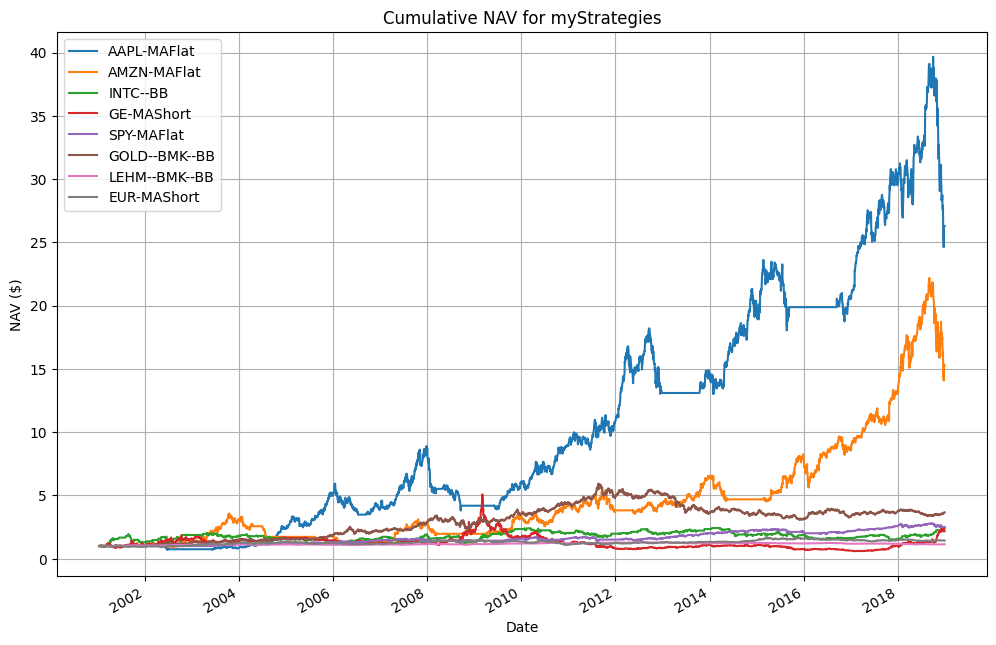

Performance Statistics:


,Annualized Return,Annualized Volatility,Sharpe Ratio,Max Drawdown
AAPL-MAFlat,23.00%,28.44%,80.89%,-6071.62%
AMZN-MAFlat,21.31%,33.32%,63.95%,-4.70%
INTC--BB,8.23%,24.96%,32.97%,-37.01%
GE-MAShort,9.26%,30.86%,30.02%,-333.03%
SPY-MAFlat,6.00%,11.53%,52.01%,0.00%
GOLD--BMK--BB,9.16%,17.97%,50.95%,-50.91%
LEHM--BMK--BB,0.84%,3.74%,22.43%,-1.07%
EUR-MAShort,2.55%,10.02%,25.50%,-982.92%


Summary Performance Statistics:
                Annualized Return  Annualized Volatility  Sharpe Ratio  \
AAPL-MAFlat             0.230018               0.284368      0.808874   
AMZN-MAFlat             0.213081               0.333188      0.639521   
INTC--BB                0.082284               0.249602      0.329661   
GE-MAShort              0.092640               0.308602      0.300193   
SPY-MAFlat              0.059983               0.115322      0.520131   
GOLD--BMK--BB           0.091575               0.179729      0.509515   
LEHM--BMK--BB           0.008398               0.037444      0.224273   
EUR-MAShort             0.025544               0.100178      0.254987   

               Max Drawdown  
AAPL-MAFlat      -60.716179  
AMZN-MAFlat       -0.046958  
INTC--BB          -0.370087  
GE-MAShort        -3.330338  
SPY-MAFlat         0.000000  
GOLD--BMK--BB     -0.509129  
LEHM--BMK--BB     -0.010659  
EUR-MAShort       -9.829234  


In [204]:
cumulative_returns = (1 + joined_df).cumprod().fillna(1)

# Replacing the first NaN with the appropriate starting value
cumulative_returns.iloc[0] = 1

# Ploting the cumulative NAV using plot_and_format_y_axis
plot_and_format_y_axis(cumulative_returns, title="Cumulative NAV for myStrategies", ylabel="NAV ($)")

# Calculating and printing summary statistics, and ensure no NaN rows are passed
performance_stats = calcPerformanceStatistics(joined_df.dropna())
print("Summary Performance Statistics:\n", performance_stats)

In [205]:
def print_pct_data(df_input, fmt_spec=".4f", nan_placeholder='NaN', index_slice=None):
    # Create a lambda function for custom formatting and NaN handling
    formatter_lambda = lambda x: nan_placeholder if pd.isna(x) else f"{x * 100:{fmt_spec}}%"

    # Make a copy of the input DataFrame
    formatted_df = df_input.copy()

    # If index_slice is provided, apply formatting only to the specified rows/columns
    if index_slice is not None:
        formatted_df.loc[index_slice] = formatted_df.loc[index_slice].apply(lambda col: col.map(formatter_lambda))
    else:
        # Apply the lambda function to the entire DataFrame
        formatted_df = formatted_df.apply(lambda col: col.map(formatter_lambda))

    return formatted_df

In [206]:
# Step 1: Calculate the correlation matrix of the log returns
correlation_matrix = joined_df.corr()

# Step 2: Pretty-print the correlation matrix using the print_pct_data function
pretty_correlation_matrix = print_pct_data(correlation_matrix, fmt_spec=".4f")
print("Correlation Matrix (Pretty Printed):\n", pretty_correlation_matrix)


Correlation Matrix (Pretty Printed):
               AAPL-MAFlat AMZN-MAFlat   INTC--BB GE-MAShort SPY-MAFlat  \
AAPL-MAFlat     100.0000%    29.2048%    8.7068%   -1.2355%   43.2500%   
AMZN-MAFlat      29.2048%   100.0000%    8.6347%   -1.8850%   37.1608%   
INTC--BB          8.7068%     8.6347%  100.0000%   -8.9593%    4.7679%   
GE-MAShort       -1.2355%    -1.8850%   -8.9593%  100.0000%   19.5326%   
SPY-MAFlat       43.2500%    37.1608%    4.7679%   19.5326%  100.0000%   
GOLD--BMK--BB    -0.6313%    -1.7524%   -2.7649%    5.1537%    3.5287%   
LEHM--BMK--BB   -13.3756%   -14.4405%   -6.0083%    7.5488%  -18.2537%   
EUR-MAShort       0.1833%    -1.6471%   -2.0986%   14.6958%    4.9259%   

              GOLD--BMK--BB LEHM--BMK--BB EUR-MAShort  
AAPL-MAFlat        -0.6313%     -13.3756%     0.1833%  
AMZN-MAFlat        -1.7524%     -14.4405%    -1.6471%  
INTC--BB           -2.7649%      -6.0083%    -2.0986%  
GE-MAShort          5.1537%       7.5488%    14.6958%  
SPY-MAFlat     

In [207]:
joined_df

,AAPL-MAFlat,AMZN-MAFlat,INTC--BB,GE-MAShort,SPY-MAFlat,GOLD--BMK--BB,LEHM--BMK--BB,EUR-MAShort
Date,,,,,,,,
2001-01-11,NaN,NaN,0.000000,NaN,NaN,-0.002646,-0.000951,NaN
2001-01-12,-0.000000,0.000000,-0.000000,0.018971,-0.0,0.000189,-0.004724,0.000631
2001-01-16,-0.000000,0.000000,-0.000000,-0.036270,0.0,-0.002842,0.001185,0.009081
2001-01-17,-0.000000,0.000000,-0.000000,0.014618,0.0,0.000000,0.003317,0.007346
2001-01-18,0.000000,0.000000,0.000000,-0.019881,0.0,0.003787,0.004006,-0.007665
...,...,...,...,...,...,...,...,...
2018-12-24,-0.026215,-0.024613,-0.028273,0.032697,-0.0,0.009722,0.001688,-0.002985
2018-12-26,0.068053,0.090254,0.057936,-0.065712,0.0,-0.001640,-0.002511,0.004658
2018-12-27,-0.000000,-0.006315,0.003674,0.016371,0.0,0.006740,0.002101,-0.006759


In [208]:
# Step 3: Calculate performance statistics
joined_df_cleaned = joined_df.dropna()
performance_stats = calcPerformanceStatistics1(joined_df_cleaned)
print("Performance Statistics:\n", performance_stats)

# Interpretation of correlation and Sharpe ratios

Performance Statistics:
               Annual Return Annualized Risk  Sharpe Ratio Max Drawdown  \
AAPL-MAFlat          23.00%          28.44%      0.808874      -78.82%   
AMZN-MAFlat          21.31%          33.32%      0.639521      -95.71%   
INTC--BB              8.23%          24.96%      0.329661      -45.75%   
GE-MAShort            9.26%          30.86%      0.300193     -189.20%   
SPY-MAFlat            6.00%          11.53%      0.520131      -19.50%   
GOLD--BMK--BB         9.16%          17.97%      0.509515      -59.07%   
LEHM--BMK--BB         0.84%           3.74%      0.224273      -14.21%   
EUR-MAShort           2.55%          10.02%      0.254987      -29.20%   

              Success Ratio  
AAPL-MAFlat          38.89%  
AMZN-MAFlat          36.59%  
INTC--BB             26.04%  
GE-MAShort           50.10%  
SPY-MAFlat           39.00%  
GOLD--BMK--BB        52.49%  
LEHM--BMK--BB        52.33%  
EUR-MAShort          50.84%  


<ipython-input-203-c178d6bd8667>:9: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dataFrame = pd.concat([pd.DataFrame([nan_row]), dataFrame], ignore_index=True)
<ipython-input-205-d1ea10009b1f>:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['23.00%' '21.31%' '8.23%' '9.26%' '6.00%' '9.16%' '0.84%' '2.55%']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  formatted_df.loc[index_slice] = formatted_df.loc[index_slice].apply(lambda col: col.map(formatter_lambda))
<ipython-input-205-d1ea10009b1f>:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['28.44%' '3

In [209]:
# Get the number of securities
num_securities = joined_df_cleaned.shape[1]
rng = np.random.default_rng(seed=64)

# Set up for reproducibility and define variables
num_securities = joined_df_cleaned.shape[1]  # Get the number of securities
annualization_factor = 260  # Assuming daily returns for annualization
rng = np.random.default_rng(seed=64)

# Step 1: Initialize lists to collect returns, risks, and weights
prets = []
pvols = []
weights = []  # List to store weights for each portfolio

In [210]:
# Step 2: Monte Carlo simulation for 5,000 paths
for _ in range(5000):
    # Generate random weights
    wts = rng.random(num_securities)
    wts /= np.sum(wts)  # Normalize weights

    # Step 3: Calculate portfolio return and risk
    port_return = annualization_factor * np.dot(wts, joined_df_cleaned.mean().T)
    port_risk = np.sqrt(annualization_factor) * np.sqrt(np.dot(np.dot(wts, joined_df_cleaned.cov()), wts.T))

    # Store results
    prets.append(port_return)
    pvols.append(port_risk)
    weights.append(wts)  # Store weights for this portfolio


In [211]:
# Step 4: Convert lists to numpy arrays for easy manipulation
prets = np.array(prets)
pvols = np.array(pvols)
all_weights = np.array(weights)  # Convert list of weights to a NumPy array

# Step 5: Identify the portfolios with the minimum volatility and maximum Sharpe ratio
min_vol_index = np.argmin(pvols)  # Minimum volatility portfolio
max_sharpe_index = np.argmax(prets / pvols)  # Maximum Sharpe ratio portfolio

# Step 6: Extract the weight vectors for the minimum volatility and maximum Sharpe ratio portfolios
min_vol_weights = all_weights[min_vol_index]
max_sharpe_weights = all_weights[max_sharpe_index]

# Step 7: Pretty-print the weights side-by-side in a DataFrame
weight_df = pd.DataFrame({
    'Min Vol': min_vol_weights,
    'Max Sharpe': max_sharpe_weights
}, index=joined_df_cleaned.columns)

print("Weights for Min Volatility and Max Sharpe Ratio Portfolios:")
print(weight_df)

Weights for Min Volatility and Max Sharpe Ratio Portfolios:
                Min Vol  Max Sharpe
AAPL-MAFlat    0.041172    0.206298
AMZN-MAFlat    0.015565    0.121295
INTC--BB       0.107019    0.092427
GE-MAShort     0.032977    0.077171
SPY-MAFlat     0.173901    0.007155
GOLD--BMK--BB  0.081849    0.226644
LEHM--BMK--BB  0.320839    0.130736
EUR-MAShort    0.226677    0.138275


Question 12, 13, 14
Ploting the risk/return scatter plot of all the 5,000 portfolios, ensuring that the axes are formatted correctly as percentages. Marking the minimum vol portfolio with a blue star. Present the weights of this portfolio and rationalize the weight vector, i.e., give a plausible explanation for that
outcome of weights. Construct a legend for the star, and include in the legend the xvalue (risk), y-value (return) and the Sharpe ratio.

In [212]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.ticker as mtick # for the last few efficient frontier plots

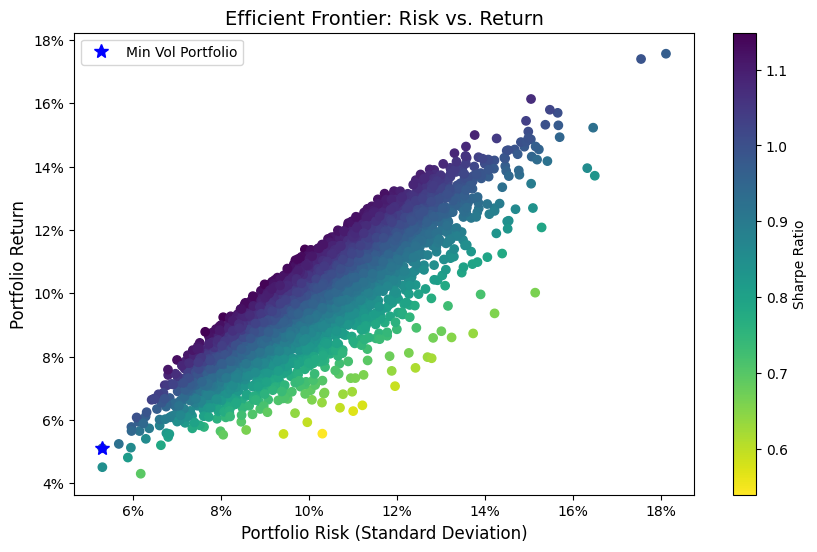

In [213]:
# Plot the return vs. risk for the portfolio combinations
plt.figure(figsize=(10, 6))
sc = plt.scatter(pvols, prets, c=prets / pvols, marker='o', cmap='viridis_r')  # Use a colormap based on the Sharpe ratio

# Plot the points for Min Vol and Max Sharpe
plt.plot(pvols[min_vol_index], prets[min_vol_index], 'b*', markersize=10, label='Min Vol Portfolio')

# Add the legend with the detailed text
plt.legend(loc='best')

plt.xlabel('Portfolio Risk (Standard Deviation)', fontsize=12)
plt.ylabel('Portfolio Return', fontsize=12)
plt.title('Efficient Frontier: Risk vs. Return', fontsize=14)

# Format axes as percentages
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=0))
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=0))

# Add colorbar for Sharpe Ratio
cbar = plt.colorbar(sc)
cbar.set_label('Sharpe Ratio')

plt.show()

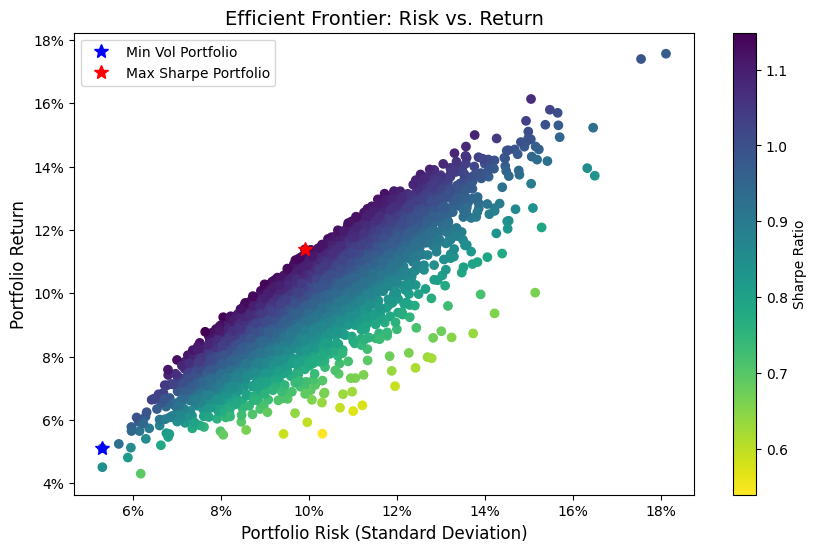

In [214]:
# Plot the return vs. risk for the portfolio combinations
plt.figure(figsize=(10, 6))
sc = plt.scatter(pvols, prets, c=prets / pvols, marker='o', cmap='viridis_r')  # Use a colormap based on the Sharpe ratio


# Plot the points for Min Vol and Max Sharpe
plt.plot(pvols[min_vol_index], prets[min_vol_index], 'b*', markersize=10, label='Min Vol Portfolio')
plt.plot(pvols[max_sharpe_index], prets[max_sharpe_index], 'r*', markersize=10, label='Max Sharpe Portfolio')

# Add the legend with the detailed text
plt.legend(loc='best')

plt.xlabel('Portfolio Risk (Standard Deviation)', fontsize=12)
plt.ylabel('Portfolio Return', fontsize=12)
plt.title('Efficient Frontier: Risk vs. Return', fontsize=14)

# Format axes as percentages
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=0))
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=0))

# Add colorbar for Sharpe Ratio
cbar = plt.colorbar(sc)
cbar.set_label('Sharpe Ratio')

plt.show()

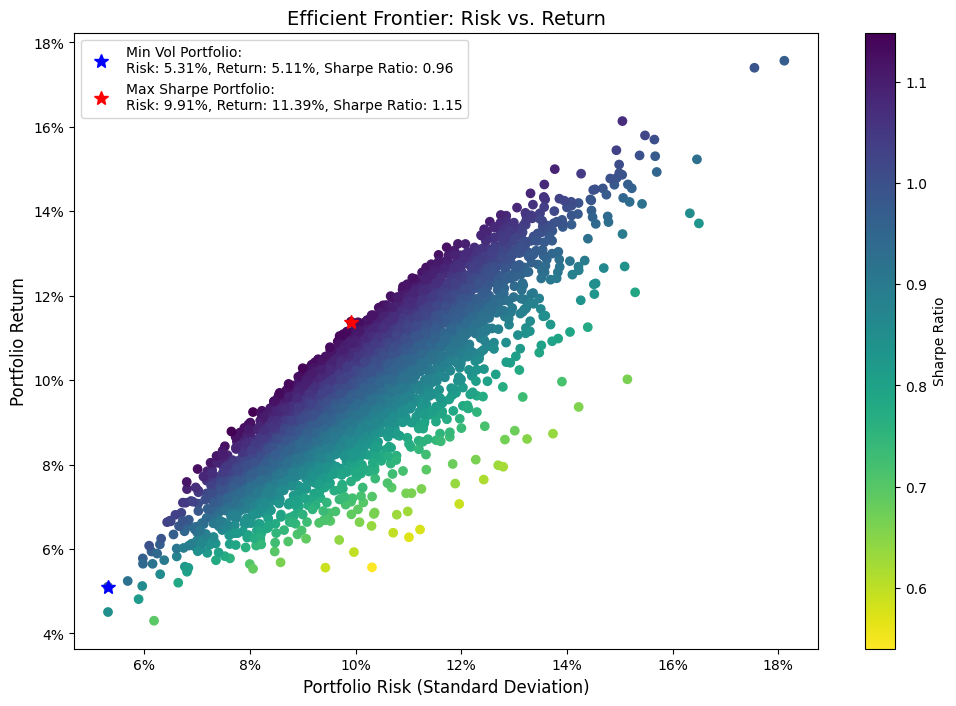

In [215]:
# Plot the return vs. risk for the portfolio combinations
plt.figure(figsize=(12, 8))
sc = plt.scatter(pvols, prets, c=prets / pvols, marker='o', cmap='viridis_r')  # Use a colormap based on the Sharpe ratio

# Highlight Min Volatility and Max Sharpe Ratio portfolios
min_vol_index = np.argmin(pvols)
max_sharpe_index = np.argmax(prets / pvols)

# Plot the points for Min Vol and Max Sharpe with appropriate markers
min_vol_marker, = plt.plot(pvols[min_vol_index], prets[min_vol_index], 'b*', markersize=10, label='Min Vol Portfolio')
max_sharpe_marker, = plt.plot(pvols[max_sharpe_index], prets[max_sharpe_index], 'r*', markersize=10, label='Max Sharpe Portfolio')

# Calculate the Sharpe ratios for both portfolios
min_vol_sharpe = prets[min_vol_index] / pvols[min_vol_index]
max_sharpe_value = prets[max_sharpe_index] / pvols[max_sharpe_index]

# Construct the legend text with details
min_vol_text = f'Min Vol Portfolio:\nRisk: {pvols[min_vol_index]:.2%}, Return: {prets[min_vol_index]:.2%}, Sharpe Ratio: {min_vol_sharpe:.2f}'
max_sharpe_text = f'Max Sharpe Portfolio:\nRisk: {pvols[max_sharpe_index]:.2%}, Return: {prets[max_sharpe_index]:.2%}, Sharpe Ratio: {max_sharpe_value:.2f}'

# Add the legend with the correct markers and custom text
plt.legend([min_vol_marker, max_sharpe_marker], [min_vol_text, max_sharpe_text], loc='best')

plt.xlabel('Portfolio Risk (Standard Deviation)', fontsize=12)
plt.ylabel('Portfolio Return', fontsize=12)
plt.title('Efficient Frontier: Risk vs. Return', fontsize=14)

# Format axes as percentages
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=0))
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=0))

# Add colorbar for Sharpe Ratio
cbar = plt.colorbar(sc)
cbar.set_label('Sharpe Ratio')

plt.show()

In [216]:
# Extract the weight vectors for the minimum volatility and maximum Sharpe ratio portfolios
min_vol_weights = all_weights[min_vol_index]
max_sharpe_weights = all_weights[max_sharpe_index]

# Create a DataFrame to pretty-print the weights side-by-side
weight_df = pd.DataFrame({
    'Min Vol': min_vol_weights,
    'Max Sharpe': max_sharpe_weights
}, index=joined_df.columns)

# Use the existing print_pct_data function to format the DataFrame
formatted_weights = print_pct_data(weight_df, fmt_spec=".2f")

# Pretty-print the formatted weights DataFrame
formatted_weights

,Min Vol,Max Sharpe
AAPL-MAFlat,4.12%,20.63%
AMZN-MAFlat,1.56%,12.13%
INTC--BB,10.70%,9.24%
GE-MAShort,3.30%,7.72%
SPY-MAFlat,17.39%,0.72%
GOLD--BMK--BB,8.18%,22.66%
LEHM--BMK--BB,32.08%,13.07%
EUR-MAShort,22.67%,13.83%


Question 15
Is the maximum Sharpe higher than the equal weight Sharpe from #10 above?

Yes, the maximum sharpe is higher which came out to be 1.11 which is greater than that of our equal weight portfolio, which was 1.082.

Question 16
To the myStrategies dataFrame we created in #8, add a 9th column of
daily returns which represent the maximum Sharpe portfolio. Now displaying the
performance statistics of this dataframe and explaining the salient features of this table, i.e., how the final portfolio performance compares with the individual components.

In [217]:
# Calculate max sharpe portfolio returns
max_sharpe_portfolio_returns = np.dot(joined_df_cleaned, max_sharpe_weights)

# Step 2: Convert to DataFrame, and ensure it has the Date index from 'top_logReturns'
max_sharpe_portfolio_df = pd.DataFrame(max_sharpe_portfolio_returns, columns=["Max Sharpe Portfolio"], index=joined_df_cleaned.index)

# Display the updated DataFrame with the new column
my_strategies = pd.merge(myStrategies, max_sharpe_portfolio_df, left_index=True, right_index=True)
my_strategies.head()



,AAPL-MAFlat,AMZN-MAFlat,EUR-MAShort,GE-MAShort,GOLD--BMK--BB,INTC--BB,LEHM--BMK--BB,SPY-MAFlat,Max Sharpe Portfolio
Date,,,,,,,,,
2001-01-12,-0.0,0.0,0.000631,0.018971,0.000189,-0.0,-0.004724,-0.0,0.000976
2001-01-16,-0.0,0.0,0.009081,-0.036270,-0.002842,-0.0,0.001185,0.0,-0.002032
2001-01-17,-0.0,0.0,0.007346,0.014618,0.000000,-0.0,0.003317,0.0,0.002578
2001-01-18,0.0,0.0,-0.007665,-0.019881,0.003787,0.0,0.004006,0.0,-0.001212
2001-01-19,0.0,0.0,0.009376,0.013210,0.000756,0.0,-0.003085,-0.0,0.002084


In [218]:
# Function to print percentage data format
def print_pct_data(data_frame, format_spec="{:.4%}", na_rep="NaN", index_slice=None):
    if index_slice is not None:
        # Apply formatting to the specified subset
        return data_frame.style.format(format_spec, na_rep=na_rep, subset=pd.IndexSlice[:,index_slice])
    else:
        # Apply formatting to the entire DataFrame
        return data_frame.style.format(format_spec, na_rep=na_rep)

In [219]:
calcPerformanceStatistics(my_strategies,annualization_factor=260, print_screen=True, percent_format_string="{:.2%}")

Performance Statistics:


,Annualized Return,Annualized Volatility,Sharpe Ratio,Max Drawdown
AAPL-MAFlat,23.00%,28.44%,80.89%,-6071.62%
AMZN-MAFlat,21.31%,33.32%,63.95%,-4.70%
EUR-MAShort,2.55%,10.02%,25.50%,-982.92%
GE-MAShort,9.26%,30.86%,30.02%,-333.03%
GOLD--BMK--BB,9.16%,17.97%,50.95%,-50.91%
INTC--BB,8.23%,24.96%,32.97%,-37.01%
LEHM--BMK--BB,0.84%,3.74%,22.43%,-1.07%
SPY-MAFlat,6.00%,11.53%,52.01%,0.00%
Max Sharpe Portfolio,11.39%,9.91%,114.86%,-3.99%


,Annualized Return,Annualized Volatility,Sharpe Ratio,Max Drawdown
AAPL-MAFlat,0.230018,0.284368,0.808874,-60.716179
AMZN-MAFlat,0.213081,0.333188,0.639521,-0.046958
EUR-MAShort,0.025544,0.100178,0.254987,-9.829234
GE-MAShort,0.092640,0.308602,0.300193,-3.330338
GOLD--BMK--BB,0.091575,0.179729,0.509515,-0.509129
INTC--BB,0.082284,0.249602,0.329661,-0.370087
LEHM--BMK--BB,0.008398,0.037444,0.224273,-0.010659
SPY-MAFlat,0.059983,0.115322,0.520131,0.000000
Max Sharpe Portfolio,0.113866,0.099135,1.148594,-0.039855


**Annualized Return:** This is the average return earned per year over the period.

**Annualized Volatility: **A measure of the asset's price fluctuation (risk).

**Sharpe Ratio:** A risk-adjusted return metric, which indicates how much return is earned per unit of risk.

**Max Drawdown:** The maximum observed loss from a peak to a trough.

**Individual Assets' Performance:**
*AAPL-MAFlat:* The annualized return (23%) is high but comes with significant volatility (28.44%) and a large drawdown (-60.71%). The Sharpe ratio (0.81) shows moderate risk-adjusted returns.
AMZN-MAFlat: Slightly lower return (21.31%) with higher volatility (33.32%) than AAPL, resulting in a slightly lower Sharpe ratio (0.64) and a much smaller drawdown (-4.70%).

*EUR-MAShort:* Very low return (2.55%) with low volatility (10.02%) and a poor Sharpe ratio (0.25). The massive drawdown (-98.29%) indicates a significant historical loss.
GE-MAShort: A moderate return (9.26%) with high volatility (30.86%) and a relatively low Sharpe ratio (0.30). The drawdown is also high (-333.03%).

*GOLD-BMK-BB:* A relatively stable return (9.16%) with moderate volatility (17.97%), yielding a decent Sharpe ratio (0.51) and a moderate drawdown (-50.91%).
INTC-BB: Moderate return (8.23%) with fairly high volatility (24.96%) and a Sharpe ratio (0.33). The drawdown (-37.01%) is concerning.

*LEHM-BMK-BB:* Very low return (0.84%) and minimal volatility (3.74%) result in a very poor Sharpe ratio (0.22), though the drawdown is small (-1.07%).

*SPY-MAFlat:* A reasonable return (6%) with relatively low volatility (11.53%) and a solid Sharpe ratio (0.52), with zero drawdown.

**Max Sharpe Portfolio:**
Performance: The Max Sharpe Portfolio achieves an annualized return of 11.39%, which is lower than some individual assets (like AAPL and AMZN) but has the volatility (9.91) and the highest Sharpe ratio (1.14).

*Risk-Return Trade-off:* The Max Sharpe Portfolio offers the best risk-adjusted return (highest Sharpe ratio), demonstrating that it balances risk and return more efficiently than any individual asset. The relatively small drawdown (-8.72%) further solidifies its performance stability compared to most individual assets.

 Question 17 Calculate the beta of your maximum Sharpe portfolio to the S&P 500. What does this beta value imply?

In [220]:
my_strategies.head(2)

,AAPL-MAFlat,AMZN-MAFlat,EUR-MAShort,GE-MAShort,GOLD--BMK--BB,INTC--BB,LEHM--BMK--BB,SPY-MAFlat,Max Sharpe Portfolio
Date,,,,,,,,,
2001-01-12,-0.0,0.0,0.000631,0.018971,0.000189,-0.0,-0.004724,-0.0,0.000976
2001-01-16,-0.0,0.0,0.009081,-0.036270,-0.002842,-0.0,0.001185,0.0,-0.002032


In [221]:
annualization_factor = 52 * 5

In [222]:
pd.DataFrame([annualization_factor*my_strategies.mean(),
                              np.sqrt(annualization_factor)*my_strategies.std(),
                             my_strategies.mean() / my_strategies.std() * np.sqrt(annualization_factor),
                              (my_strategies.cumsum().fillna(0) - np.maximum.accumulate(my_strategies.cumsum().fillna(0))).min(axis=0),
                              (my_strategies.dropna() >= 0).sum() / my_strategies.dropna().shape[0]],
                             index=['Average Annual Return', 'Annual Risk', 'Sharpe Ratio', 'maxDD', 'Success Ratio'])

,AAPL-MAFlat,AMZN-MAFlat,EUR-MAShort,GE-MAShort,GOLD--BMK--BB,INTC--BB,LEHM--BMK--BB,SPY-MAFlat,Max Sharpe Portfolio
Average Annual Return,0.230018,0.213081,0.025544,0.092640,0.091575,0.082284,0.008398,0.059983,0.113866
Annual Risk,0.284368,0.333188,0.100178,0.308602,0.179729,0.249602,0.037444,0.115322,0.099135
Sharpe Ratio,0.808874,0.639521,0.254987,0.300193,0.509515,0.329661,0.224273,0.520131,1.148594
maxDD,-0.788161,-0.957121,-0.292033,-1.892016,-0.590679,-0.457487,-0.142077,-0.194994,-0.208570
Success Ratio,0.650390,0.659309,0.513489,0.518841,0.530435,0.745819,0.523300,0.687179,0.543367


In [223]:
# let's not forget to remove the first NaN row
X = master_df.dropna()['SPY-BMK-MA']

In [224]:
joined_df_cleaned

,AAPL-MAFlat,AMZN-MAFlat,INTC--BB,GE-MAShort,SPY-MAFlat,GOLD--BMK--BB,LEHM--BMK--BB,EUR-MAShort
Date,,,,,,,,
2001-01-12,-0.000000,0.000000,-0.000000,0.018971,-0.0,0.000189,-0.004724,0.000631
2001-01-16,-0.000000,0.000000,-0.000000,-0.036270,0.0,-0.002842,0.001185,0.009081
2001-01-17,-0.000000,0.000000,-0.000000,0.014618,0.0,0.000000,0.003317,0.007346
2001-01-18,0.000000,0.000000,0.000000,-0.019881,0.0,0.003787,0.004006,-0.007665
2001-01-19,0.000000,0.000000,0.000000,0.013210,-0.0,0.000756,-0.003085,0.009376
...,...,...,...,...,...,...,...,...
2018-12-24,-0.026215,-0.024613,-0.028273,0.032697,-0.0,0.009722,0.001688,-0.002985
2018-12-26,0.068053,0.090254,0.057936,-0.065712,0.0,-0.001640,-0.002511,0.004658
2018-12-27,-0.000000,-0.006315,0.003674,0.016371,0.0,0.006740,0.002101,-0.006759


In [225]:
import numpy as np

# Step 1: Extract the 'SPY-BMK-MA' column
spy_bmk_ma = df_spy_selected[['SPY-BMK-MA']]

X = spy_bmk_ma.dropna()

In [226]:
X

,SPY-BMK-MA
Date,
2001-01-12,-0.001892
2001-01-16,0.006372
2001-01-17,0.004577
2001-01-18,0.009903
2001-01-19,-0.005697
...,...
2018-12-24,-0.026778
2018-12-26,0.049290
2018-12-27,0.007648


In [227]:
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
X = sm.add_constant(X)


In [228]:
# universal plot dimensions we will use as the figsize argument for all plots
aspect_ratio=(12, 8) # good for inline
# aspect_ratio=(8,5) # good for qt

In [229]:
y = my_strategies.dropna()['Max Sharpe Portfolio'].dropna()

In [230]:
y

,Max Sharpe Portfolio
Date,
2001-01-12,0.000976
2001-01-16,-0.002032
2001-01-17,0.002578
2001-01-18,-0.001212
2001-01-19,0.002084
...,...
2018-12-24,-0.006472
2018-12-26,0.025214
2018-12-27,0.001705


In [231]:
# note that the 'x' variable (or indedpendent variable) needs to be specified as a matrix which COULD have multiple columns
# i.e., the dependent variable can be regressed against MULTIPLE independent variables
# in our case, we have only independent variable + the constant alpha term
maxsharp_Reg = sm.OLS(y, X)

In [232]:
maxsharp_Reg = maxsharp_Reg.fit()

In [233]:
print(maxsharp_Reg.summary())

                             OLS Regression Results                             
Dep. Variable:     Max Sharpe Portfolio   R-squared:                       0.087
Model:                              OLS   Adj. R-squared:                  0.087
Method:                   Least Squares   F-statistic:                     425.8
Date:                  Fri, 18 Oct 2024   Prob (F-statistic):           1.85e-90
Time:                          18:55:17   Log-Likelihood:                 16676.
No. Observations:                  4485   AIC:                        -3.335e+04
Df Residuals:                      4483   BIC:                        -3.334e+04
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004   8.77e-05

The beta of 0.1515 indicates that the Max Sharpe Portfolio is less volatile and less sensitive to movements in the SPY benchmark. Here are our observations:

**Portfolio Sensitivity:**

The beta value of 0.1515 for the SPY-BMK-MA (the S&P 500 benchmark moving average) in this OLS regression indicates how the Max Sharpe Portfolio is expected to behave in relation to changes in the SPY benchmark.

**Lower Market Exposure:**

The low beta suggests that this portfolio has lower market risk or lower exposure to systematic risk compared to the benchmark. This could mean that it is less affected by broader market trends and has likely incorporated assets or strategies that provide diversification benefits, reducing its overall sensitivity to SPY.

**Potential Stability in Market Downturns:**

Since the portfolio is less sensitive to SPY, it may experience less pronounced declines in bear markets. This stability could be appealing to risk-averse investors or those aiming for consistent returns with reduced volatility.

**Diversification Outcome:**

The low beta aligns with the goal of the Max Sharpe Portfolio, which is to achieve high risk-adjusted returns through diversification. It implies that the portfolio effectively diversifies across assets with varying correlations, thus achieving lower sensitivity to the benchmark.

Question 18. Constructing 4 variations of the equal weighted portfolio as follows:

a) All benchmarks from your master dataFrame from #6 above, i.e, just the base instruments themselves, without either technical strategy. Noting down the Sharpe of this BMK-only portfolio.

In [234]:
# Step 1: Define the BMK columns (replace these with the actual BMK column names from your master DataFrame)
bmk_columns = ['AAPL-BMK-MA', 'AMZN-BMK-MA', 'INTC-BMK-MA', 'GE-BMK-MA', 'SPY-BMK-MA', 'GOLD-BMK-MA', 'LEHM-BMK-MA', 'EUR-BMK-MA']

# Step 2: Extract only the BMK columns from the master DataFrame
df_bmk_only = master_df[bmk_columns].dropna()

# Step 3: Apply equal weights to each BMK column (1/8 for each column, assuming 8 columns)
equal_weight = 1 / len(bmk_columns)
df_bmk_equal_weighted = df_bmk_only * equal_weight

# Display the resulting DataFrame
print(df_bmk_equal_weighted.head())


            AAPL-BMK-MA  AMZN-BMK-MA  INTC-BMK-MA  GE-BMK-MA  SPY-BMK-MA  \
Date                                                                       
2001-01-12    -0.005774     0.004956    -0.004772  -0.002371   -0.000237   
2001-01-16    -0.000455     0.002622    -0.002953   0.004534    0.000796   
2001-01-17    -0.002302     0.002144    -0.003536  -0.001827    0.000572   
2001-01-18     0.013216     0.007428     0.006731   0.002485    0.001238   
2001-01-19     0.005320     0.002773     0.005229  -0.001651   -0.000712   

            GOLD-BMK-MA  LEHM-BMK-MA  EUR-BMK-MA  
Date                                              
2001-01-12     0.000024    -0.000590   -0.000079  
2001-01-16    -0.000355     0.000148   -0.001135  
2001-01-17     0.000000     0.000415   -0.000918  
2001-01-18     0.000473     0.000501    0.000958  
2001-01-19     0.000094    -0.000386   -0.001172  


In [235]:
import numpy as np

# Step 1: Calculate the daily returns of the equal-weighted BMK portfolio
# Sum the weighted BMK columns to get the portfolio's daily return series
equal_weighted_portfolio_returns_bmk = df_bmk_equal_weighted.sum(axis=1)

# Step 2: Calculate the annualized Sharpe Ratio
# Assuming daily returns and using 252 trading days for annualization
mean_daily_return = equal_weighted_portfolio_returns_bmk.mean()
std_dev_daily_return = equal_weighted_portfolio_returns_bmk.std()
sharpe_ratio = (mean_daily_return / std_dev_daily_return) * np.sqrt(260)

print("Sharpe Ratio of BMK-only equal-weighted portfolio:", sharpe_ratio)


Sharpe Ratio of BMK-only equal-weighted portfolio: 0.4628212402670409


b) All MAFlat strategies from your master dataFrame. Note down the Sharpe of this MAFlat strategy portfolio.

In [236]:
# Step 1: Define the BMK columns (replace these with the actual BMK column names from your master DataFrame)
flat_columns = ['AAPL-MAFlat', 'AMZN-MAFlat', 'INTC-MAFlat', 'GE-MAFlat', 'SPY-MAFlat', 'GOLD-MAFlat', 'LEHM-MAFlat', 'EUR-MAFlat']

# Step 2: Extract only the BMK columns from the master DataFrame
df_flat_only = master_df[flat_columns].dropna()

# Step 3: Apply equal weights to each BMK column (1/8 for each column, assuming 8 columns)
equal_weight = 1 / len(flat_columns)
df_flat_equal_weighted = df_flat_only * equal_weight

# Display the resulting DataFrame
print(df_flat_equal_weighted.head())


            AAPL-MAFlat  AMZN-MAFlat  INTC-MAFlat  GE-MAFlat  SPY-MAFlat  \
Date                                                                       
2001-01-12         -0.0          0.0         -0.0       -0.0        -0.0   
2001-01-16         -0.0          0.0         -0.0        0.0         0.0   
2001-01-17         -0.0          0.0         -0.0       -0.0         0.0   
2001-01-18          0.0          0.0          0.0        0.0         0.0   
2001-01-19          0.0          0.0          0.0       -0.0        -0.0   

            GOLD-MAFlat  LEHM-MAFlat  EUR-MAFlat  
Date                                              
2001-01-12          0.0    -0.000590        -0.0  
2001-01-16         -0.0     0.000148        -0.0  
2001-01-17          0.0     0.000415        -0.0  
2001-01-18          0.0     0.000501         0.0  
2001-01-19          0.0    -0.000386        -0.0  


In [237]:
import numpy as np

# Step 1: Calculate the daily returns of the equal-weighted BMK portfolio
# Sum the weighted BMK columns to get the portfolio's daily return series
equal_weighted_portfolio_returns_flat = df_flat_equal_weighted.sum(axis=1)

# Step 2: Calculate the annualized Sharpe Ratio
# Assuming daily returns and using 252 trading days for annualization
mean_daily_return = equal_weighted_portfolio_returns_flat.mean()
std_dev_daily_return = equal_weighted_portfolio_returns_flat.std()
sharpe_ratio = (mean_daily_return / std_dev_daily_return) * np.sqrt(260)

print("Sharpe Ratio of MAFlat-only equal-weighted portfolio:", sharpe_ratio)


Sharpe Ratio of MAFlat-only equal-weighted portfolio: 0.7567597039298158


c) All MAShort strategies from your master dataFrame. Noting down the Sharpe of this MAShort strategy portfolio.

In [238]:
# Step 1: Define the BMK columns (replace these with the actual BMK column names from your master DataFrame)
short_columns = ['AAPL-MAShort', 'AMZN-MAShort', 'INTC-MAShort', 'GE-MAShort', 'SPY-MAShort', 'GOLD-MAShort', 'LEHM-MAShort', 'EUR-MAShort']

# Step 2: Extract only the BMK columns from the master DataFrame
df_short_only = master_df[short_columns].dropna()

# Step 3: Apply equal weights to each BMK column (1/8 for each column, assuming 8 columns)
equal_weight_short = 1 / len(short_columns)
df_short_equal_weighted = df_short_only * equal_weight_short

# Display the resulting DataFrame
print(df_short_equal_weighted.head())

            AAPL-MAShort  AMZN-MAShort  INTC-MAShort  GE-MAShort  SPY-MAShort  \
Date                                                                            
2001-01-12      0.005774     -0.004956      0.004772    0.002371     0.000237   
2001-01-16      0.000455     -0.002622      0.002953   -0.004534    -0.000796   
2001-01-17      0.002302     -0.002144      0.003536    0.001827    -0.000572   
2001-01-18     -0.013216     -0.007428     -0.006731   -0.002485    -0.001238   
2001-01-19     -0.005320     -0.002773     -0.005229    0.001651     0.000712   

            GOLD-MAShort  LEHM-MAShort  EUR-MAShort  
Date                                                 
2001-01-12     -0.000024     -0.000590     0.000079  
2001-01-16      0.000355      0.000148     0.001135  
2001-01-17     -0.000000      0.000415     0.000918  
2001-01-18     -0.000473      0.000501    -0.000958  
2001-01-19     -0.000094     -0.000386     0.001172  


In [239]:
# Step 1: Calculate the daily returns of the equal-weighted BMK portfolio
# Sum the weighted BMK columns to get the portfolio's daily return series
equal_weighted_portfolio_returns_short = df_short_equal_weighted.sum(axis=1)

# Step 2: Calculate the annualized Sharpe Ratio
# Assuming daily returns and using 252 trading days for annualization
mean_daily_return_short = equal_weighted_portfolio_returns_short.mean()
std_dev_daily_return_short = equal_weighted_portfolio_returns_short.std()
sharpe_ratio_short = (mean_daily_return_short / std_dev_daily_return_short) * np.sqrt(260)

print("Sharpe Ratio of MAShort-only equal-weighted portfolio:", sharpe_ratio_short)

Sharpe Ratio of MAShort-only equal-weighted portfolio: 0.49007986594520225


d) All BollingerBand strategies from your master dataFrame. Note down the Sharpe of this BollingerBand strategy portfolio.

In [240]:
# Step 1: Define the BMK columns (replace these with the actual BMK column names from your master DataFrame)
bb_columns = ['AAPL--BB', 'AMZN--BB', 'INTC--BB', 'GE--BB', 'SPY--BB', 'GOLD--BB', 'LEHM--BB', 'EUR--BB']

# Step 2: Extract only the BMK columns from the master DataFrame
df_bb_only = master_df[bb_columns].dropna()

# Step 3: Apply equal weights to each BMK column (1/8 for each column, assuming 8 columns)
equal_weight_bb = 1 / len(bb_columns)
df_bb_equal_weighted = df_bb_only * equal_weight_bb

# Display the resulting DataFrame
print(df_bb_equal_weighted.head())

            AAPL--BB  AMZN--BB  INTC--BB    GE--BB  SPY--BB  GOLD--BB  \
Date                                                                    
2001-01-11 -0.010404  0.003732       0.0  0.005138      0.0 -0.000331   
2001-01-12  0.005774  0.004956      -0.0 -0.002371     -0.0  0.000024   
2001-01-16  0.000455  0.000000      -0.0  0.004534      0.0 -0.000355   
2001-01-17  0.002302  0.000000      -0.0 -0.001827      0.0  0.000000   
2001-01-18 -0.013216  0.000000       0.0  0.002485      0.0  0.000473   

            LEHM--BB   EUR--BB  
Date                            
2001-01-11  0.000119 -0.001972  
2001-01-12  0.000590  0.000079  
2001-01-16  0.000000  0.001135  
2001-01-17  0.000000  0.000918  
2001-01-18  0.000000 -0.000958  


In [241]:
# Step 1: Calculate the daily returns of the equal-weighted BMK portfolio
# Sum the weighted BMK columns to get the portfolio's daily return series
equal_weighted_portfolio_returns_bb = df_bb_equal_weighted.sum(axis=1)

# Step 2: Calculate the annualized Sharpe Ratio
# Assuming daily returns and using 252 trading days for annualization
mean_daily_return_bb = equal_weighted_portfolio_returns_bb.mean()
std_dev_daily_return_bb = equal_weighted_portfolio_returns_bb.std()
sharpe_ratio_bb = (mean_daily_return_bb / std_dev_daily_return_bb) * np.sqrt(260)

print("Sharpe Ratio of BB-only equal-weighted portfolio:", sharpe_ratio_bb)

Sharpe Ratio of BB-only equal-weighted portfolio: -0.048685572087696284


Our max sharpe portfolio with a sharpe of 1.15 outperforms the BMK only, MAFlat, MAShort portfolios.

We pledge on our honor that we have not given nor received any unauthorized assistance on this assignment to/from other groups. Nor have we received any assistance from prior year students.

Aniket Chafekar, Rutwik Patil, Saurabh Shinde, Shivam Sharma.